### LSTM (Long Short-Term Memory) Explanation

An **LSTM (Long Short-Term Memory)** is a type of recurrent neural network (RNN) designed to handle sequence data and capture long-term dependencies. Unlike traditional RNNs, which struggle with remembering long-range information due to the vanishing or exploding gradient problem, LSTMs use a special architecture that allows them to retain information over longer time periods. 

This is achieved through **cell states** and **gates** that control the flow of information:

1. **Forget Gate**: Decides what information from the previous cell state to discard.
2. **Input Gate**: Determines what new information should be stored in the cell state.
3. **Output Gate**: Controls what part of the current cell state should be output as the hidden state.

The combination of these gates allows LSTMs to selectively remember or forget information, making them highly effective for tasks like:
- Time series prediction
- Natural language processing
- Speech recognition

In such tasks, understanding both short-term and long-term patterns is crucial for accurate predictions, and LSTMs are well-suited for this.

In [630]:
import torch.nn
import torch.nn  as nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader


In [631]:
data = pd.read_csv('AMZN.csv')

#only really interested in closing value

data = data[['Date', 'Close']]

In [632]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


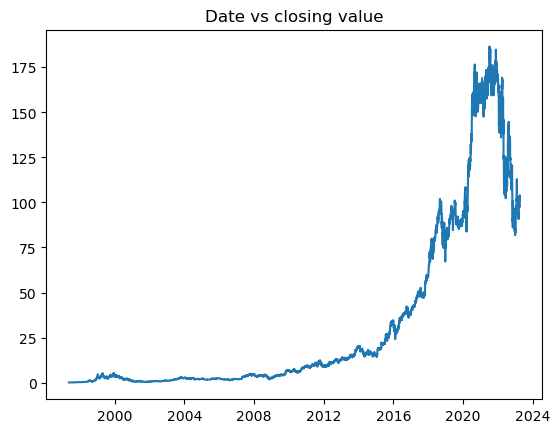

In [633]:
#plot data and closing value
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])
plt.title('Date vs closing value')
plt.show()

# Prepare the data for an LSTM

Need to convert dataframe in a way that the model will train - an LSTM looks at history ie what the closing value was today then date before then date bafore that... etc. For example:

Use the previous 6 days of data to predict the 7th day

ie - ur target vector is the 7th day
and the input matrix is the previous 6 days of data

In [634]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df) #take a deepcopy of data

    df.set_index('Date', inplace = True) #set the index to the data

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True) #drop null values

    return df

lookback =7 #how many daya hence in df upto t -7
shifted_df = prepare_dataframe_for_lstm(data,lookback)
shifted_df_numpy = shifted_df.to_numpy()

# scale the data

In [635]:
scaler = MinMaxScaler(feature_range=(-1,1))
shifted_df_numpy = scaler.fit_transform(shifted_df_numpy)

# Create X and y variables

X - number of features ie number of days to predict the data ie upto from t-1 up to t-7 in this case

y - the value of the stock on that day

In [636]:
X = shifted_df_numpy[:, 1:] #all the columns from 1 onwards
y = shifted_df_numpy[:,0] #the zeroeth column

X.shape, y.shape

((6509, 7), (6509,))

Need to flip X array as an LSTM likes the data to be the furthest away data first then most recent as its a type of recurrent nn

ie Data is from (t-7) -> (t-6)....(t-1)

In [637]:
X = dc(np.flip(X, axis = 1))

# Split data

In [638]:
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.05, random_state = 42)

split_index = int(len(X) * 0.95)

split_index

X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]


X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 7), (326, 7), (6183,), (326,))

# Reshape data

In [639]:
#extra dimension for X data
X_train = X_train.reshape((-1, lookback,1))
X_test = X_test.reshape((-1, lookback,1))

#same for y up to 2D
y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 7, 1), (326, 7, 1), (6183, 1), (326, 1))

# Convert to tensors

In [640]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6183, 7, 1]),
 torch.Size([326, 7, 1]),
 torch.Size([6183, 1]),
 torch.Size([326, 1]))

# Create dataset object

This is so not loading raw tensors into model therefore creating a dataset is best approach

In [641]:
class TimeSeriesDataset(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y #store x and y in self

    def __len__(self):
        return len(self.x) #if you pass len of x will return len, will do the same with len y
    
    def __getitem__(self, index):
        return self.x[index], self.y[index] #instruction for indexing into dataset
    
train_dataset = TimeSeriesDataset(X_train,y_train)
test_dataset = TimeSeriesDataset(X_test,y_test)

# Create Dataloaders

Used to batch data

In [642]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### How LSTM Layers Work (In-Depth)

An LSTM (Long Short-Term Memory) layer is designed to learn and retain important information over time, addressing the limitations of simpler RNNs (Recurrent Neural Networks). Here's a closer look at the components that make an LSTM powerful:

#### 1. **Inputs to an LSTM Cell**
Each LSTM cell receives three key inputs:
- The current data point from the sequence (e.g., a word in a sentence or a stock price at time \(t\)).
- The **hidden state** from the previous time step, which holds the recent knowledge of the sequence.
- The **cell state**, which is like a long-term memory storing important information over a longer period.

#### 2. **Forget Gate**
The forget gate controls what information from the past should be "forgotten" or discarded. Think of it as a filter that decides whether the past information is still useful for the task. For example, if an LSTM is processing a sentence, it might decide that the first word of the sentence is no longer relevant once it reaches the last word.

#### 3. **Input Gate**
The input gate determines what new information from the current input should be added to the memory. It works by looking at the current data point and the hidden state (short-term memory). For instance, while processing stock market data, the input gate may decide that today’s price change is important enough to update the overall memory of the model.

#### 4. **Cell State Update**
The cell state is the long-term memory of the LSTM. The forget gate adjusts the cell state by removing unimportant information, and the input gate adds new relevant information. This way, the cell state is continuously updated to hold both old and new knowledge, allowing the LSTM to learn longer patterns in the data.

#### 5. **Output Gate**
The output gate decides what part of the cell state should be used to produce the hidden state for the current time step. This hidden state can be thought of as the LSTM’s immediate "understanding" of the data. It will be passed along to the next time step (or layer) to continue processing the sequence. 

For example, in the case of a sentence, the hidden state at each word captures the LSTM’s current understanding of the sentence so far, while still allowing it to remember key information from previous words via the cell state.

#### 6. **Stacked LSTMs**
In more complex architectures, multiple LSTM layers can be stacked on top of each other. The output from the first layer becomes the input for the second, and so on. This allows the network to capture even more intricate patterns in the data, as each layer learns different aspects of the sequence.

#### 7. **Loss Function and Training**
LSTMs are trained by comparing their predictions to actual outcomes using a loss function, which calculates the error. The model is then adjusted by "backpropagating" the error through time, so it learns to make better predictions over the sequence.

#### Summary of the Flow:
1. The LSTM cell processes each input, one step at a time, while deciding what to remember or forget.
2. The **forget gate** removes irrelevant past information.
3. The **input gate** adds new useful information.
4. The **cell state** (long-term memory) is updated with both old and new knowledge.
5. The **output gate** produces the hidden state (short-term memory) for the current step.
6. Multiple layers can be stacked to capture complex patterns.

By using these gates and the memory mechanism, LSTMs are able to maintain important information over longer sequences, making them ideal for tasks where long-term dependencies matter, such as time series forecasting, text generation, and language translation.


# Create Model 

In [643]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers #can stack layers in LSTM as they are sequiential
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True) #retrun the batch size first

        #create a fully connexted layer
        self.fc = nn.Linear(hidden_size,1) #only want a return of the final close cost

    def forward(self,x):
        batch_size = x.size(0) #grab the batch size

        #The hidden state (h0) and cell state (c0) are initialized as tensors filled with zeros. 
        # Their shape is (num_stacked_layers, batch_size, hidden_size)—one set of states per LSTM layer, for each batch and hidden unit
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        # The input x (the sequence of data) is fed into the LSTM, along with the initial hidden and cell states (h0, c0).
        # The output out contains the hidden states for all time steps (not just the final one), and _ (the second return) contains the last hidden and cell states, 
        # which you can ignore here.

        out, _ = self.lstm(x,(h0,c0))


        # out[:, -1, :] selects the output from the last time step for each sample in the batch. Since you're making a prediction based on the entire sequence, 
        # the model uses the last hidden state.
        # Then, it passes the last hidden state through the fully connected layer to produce the final output (in this case, one value per sample).

        out = self.fc(out[:,-1,:])
        return out
    
# This line creates an instance of the LSTM model. input_size=1 (like one stock price at a time step),
#  hidden_size=4 (4 hidden units per layer), and num_stacked_layers=1 (a single LSTM layer).
model = LSTM(1,4,1).to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

# Training Function

In [644]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()
    
        


# Validation Function

In [645]:
def validate_one_epoch():
    model.eval()
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss/len(test_loader)

    print(f'val loss {avg_loss_across_batches:.3f}')
    print('********************************************')
    print()



In [646]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
num_epochs = 10

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.135
Batch 200, Loss: 0.014
Batch 300, Loss: 0.001

val loss 0.002
********************************************

Epoch: 2
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

val loss 0.002
********************************************

Epoch: 3
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

val loss 0.002
********************************************

Epoch: 4
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

val loss 0.002
********************************************

Epoch: 5
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

val loss 0.002
********************************************

Epoch: 6
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

val loss 0.002
********************************************

Epoch: 7
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

val loss 0.002
********************************************

Epoch: 8
Batch 100, 

# Visulise predicted data from training

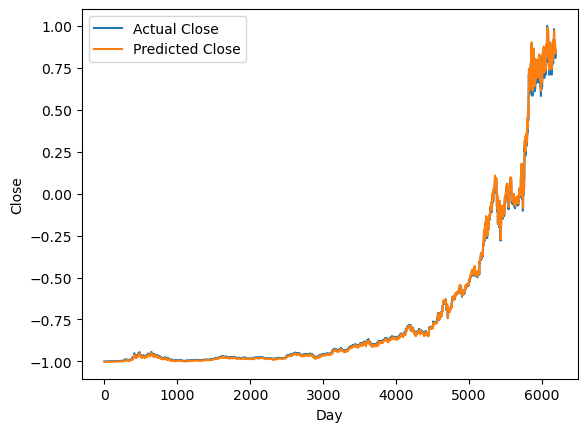

In [647]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

# Rescale to get original values

In [648]:
train_predictions = predicted.flatten() #make sure just one axis

#Purpose: Creates an array of zeros with the same number of rows as X_train and lookback + 1 columns.
#Explanation: X_train.shape[0] gives the number of samples (rows) in the training data. lookback + 1 is the
#  number of columns because you want to fit both the model predictions and the original features for inverse transformation.

dummies = np.zeros((X_train.shape[0], lookback+1)) 

#Purpose: Stores the model predictions in the first column of the dummies array.
#Explanation: train_predictions contains the predictions from your model. 
#This step puts these predictions into the first column of the dummies array. The rest of the columns in dummies will remain as zeros

dummies[:, 0] = train_predictions

#do the inverse transform to convert back
dummies = scaler.inverse_transform(dummies)

#Purpose: Extracts the first column of the transformed data and makes a deep copy of it.
# Explanation: dummies[:, 0] gives you back the original scale predictions. dc (deepcopy) is used to ensure that 
# train_predictions is a separate copy of the data, preventing unintended modifications to the original array.

train_predictions = dc(dummies[:, 0])
train_predictions

array([ -0.21043026,  -0.20802915,  -0.20859608, ..., 172.12338895,
       171.30673393, 174.28702176])

Rescale the y_train

In [649]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([7.91646265e-02, 7.65634249e-02, 7.52572660e-02, ...,
       1.69091505e+02, 1.73315001e+02, 1.68871003e+02])

# Plot graph on proper scale

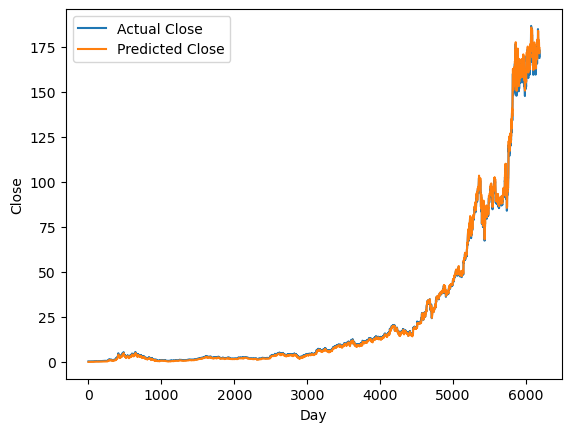

In [650]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

# Visulise test predictions

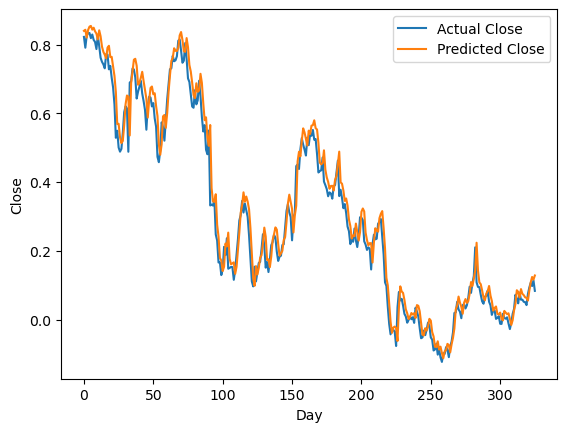

In [651]:
with torch.no_grad():
    predicted = model(X_test.to(device)).to('cpu').numpy()

plt.plot(y_test, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()